In [22]:
#Importando bibliotecas

import pandas as pd
import numpy as np
import scipy
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import statsmodels as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
# Desligando avisos
import warnings
warnings.filterwarnings("ignore")
# Option "Trace" "PB" "SS"
WGNet_Input = "PB"

Matplotlib is building the font cache; this may take a moment.


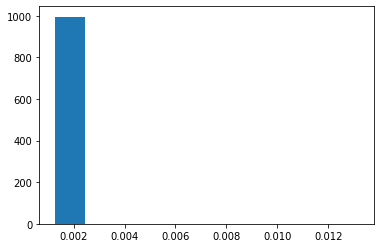

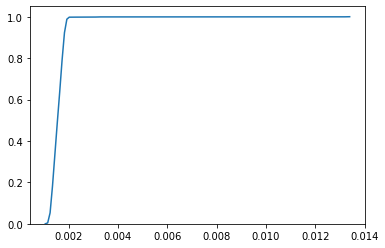

In [23]:
if WGNet_Input == "PB":
    data_set = np.loadtxt("/home/carl/Documents/Simulation/Times/data_cenario_5_delay.txt", usecols=0)
    # data_set = pd.read_csv("/home/carl/anaconda3/bin/PhaseType/Simulation/Times/data_cenario_5_delay.txt")


    data_set = np.array(data_set)
    y = data_set

    # Indexar o vetor criado anteriormente Create an index array (x) for data

    x = np.arange(len(y))
    size = len(x)
    nbins = int(np.sqrt(size))

    #Plot histograma:
    plt.hist(y)
    plt.show()


    #Com ajuda da lib Pandas podemos encontrar algumas estatísticas importantes.
    y_df = pd.DataFrame(y, columns=['Data'])
    y_df.describe()
    
    # Define the method by reader the trace
    cdf = []
    tcdf = False
    ecdf = True
    
    if tcdf:
        #Primeiro, vamos normalizar os dados
        sc=StandardScaler()
        yy = y.reshape (-1,1)
        sc.fit(yy)
        y_std =sc.transform(yy)
        y_std = y_std.flatten()
        y_std
        del yy

        #Python pode relatar avisos enquanto executa as distribuições

        # Mais distribuições podem ser encontradas no site do Scipy
        # Veja https://docs.scipy.org/doc/scipy/reference/stats.html para mais detalhes
        dist_names = ['beta',
                      'expon',
                      'gamma',
                      'lognorm',
                      'norm',
                      'loggamma',
                      'triang',
                      'uniform',
                      'weibull_min', 
                      'weibull_max']

        #Configurar listas vazias para receber os resultados
        chi_square = []
        p_values = []

        # Configurar os 50 intervalos de classe para o teste qui-quadrado
        # Os dados observados serão distribuídos uniformemente em todos os inervalos de classes
        percentile_bins = np.linspace(0,100,nbins)
        percentile_cutoffs = np.percentile(y_std, percentile_bins)
        observed_frequency, bins = (np.histogram(y_std, bins=percentile_cutoffs))
        cum_observed_frequency = np.cumsum(observed_frequency)

        # Repetir para as distribuições candidatas
        for distribution in dist_names:
            # Configure a distribuição e obtenha parâmetros de distribuição ajustados
            dist = getattr(scipy.stats, distribution)
            param = dist.fit(y_std)

            # Obter a estatística P do teste KS, arredondar para 5 casas decimais
            p = scipy.stats.kstest(y_std, distribution, args=param)[1]
            p = np.around(p, 5)
            p_values.append(p)    

            # Obter contagens esperadas nos percentis
            # Isso se baseia em uma 'função de distribuição acumulada' (cdf)
            cdf_fitted = dist.cdf(percentile_cutoffs, *param[:-2], loc=param[-2], 
                                  scale=param[-1])
            expected_frequency = []
            for bin in range(len(percentile_bins)-1):
                expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
                expected_frequency.append(expected_cdf_area)

            # calculando o qui-quadrado
            expected_frequency = np.array(expected_frequency) * size
            cum_expected_frequency = np.cumsum(expected_frequency)
            ss = sum (((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency)
            chi_square.append(ss)

        # Agrupar os resultados e classificar por qualidade de ajuste (melhor na parte superior)

        results = pd.DataFrame()
        results['Distribution'] = dist_names
        results['chi_square'] = chi_square
        results['p_value'] = p_values
        results.sort_values(['chi_square'], inplace=True)

        # Apresentar os resultados em uma tabela

        print ('\nDistributions sorted by goodness of fit:')
        print ('----------------------------------------')
        print (results)




        # Divida os dados observados em N posições para plotagem (isso pode ser alterado)
        bin_cutoffs = np.linspace(np.percentile(y,0), np.percentile(y,99), nbins)

        # Crie o gráfico
        h = plt.hist(y, bins = bin_cutoffs, color='0.75')

        # Receba as três principais distribuições da fase anterior
        number_distributions_to_plot = 1
        dist_names = results['Distribution'].iloc[0:number_distributions_to_plot]

        # Crie uma lista vazia para armazenar parâmetros de distribuição ajustada
        parameters = []

        # Faça um loop pelas distribuições para obter o ajuste e os parâmetros da linha
        for dist_name in dist_names:
            # Set up distribution and store distribution paraemters
            dist = getattr(scipy.stats, dist_name)
            param = dist.fit(y)
            parameters.append(param)

            # Obter linha para cada distribuição (e dimensionar para corresponder aos dados observados)
            pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1])
            scale_pdf = np.trapz (h[0], h[1][:-1]) / np.trapz (pdf_fitted, x)
            pdf_fitted *= scale_pdf

            # Adicione a linha ao gráfico
            plt.plot(pdf_fitted, label=dist_name)

            # Defina o eixo gráfico x para conter 99% dos dados
            # Isso pode ser removido, mas, às vezes, dados fora de padrão tornam o gráfico menos claro
            plt.xlim(0,np.percentile(y,99))

        # Adicionar legenda
        plt.legend()
        plt.show()

        # Armazenar parâmetros de distribuição em um quadro de dados (isso também pode ser salvo)
        dist_parameters = pd.DataFrame()
        dist_parameters['Distribution'] = (
                results['Distribution'].iloc[0:number_distributions_to_plot])
        dist_parameters['Distribution parameters'] = parameters

        # Printar os parâmetros
        print ('\nDistribution parameters:')
        print ('------------------------')

        for index, row in dist_parameters.iterrows():
            print ('\nDistribution:', row[0])
            print ('Parameters:', row[1] )




        ## qq and pp plots

        data = y_std.copy()
        data.sort()

        # Loop through selected distributions (as previously selected)

        for distribution in dist_names:
            # Set up distribution
            dist = getattr(scipy.stats, distribution)
            print("Dist: ",dist)
            param = dist.fit(y_std)

            # Get random numbers from distribution
            norm = dist.rvs(*param[0:-2],loc=param[-2], scale=param[-1],size = size)
            norm.sort()
            #print("Norm: ",norm)
            # Create figure
            fig = plt.figure(figsize=(8,5)) 

            # qq plot
            ax1 = fig.add_subplot(121) # Grid of 2x2, this is suplot 1
            ax1.plot(norm,data,"o")
            min_value = np.floor(min(min(norm),min(data)))
            max_value = np.ceil(max(max(norm),max(data)))
            ax1.plot([min_value,max_value],[min_value,max_value],'r--')
            ax1.set_xlim(min_value,max_value)
            ax1.set_xlabel('Theoretical quantiles')
            ax1.set_ylabel('Observed quantiles')
            title = 'qq plot for ' + distribution +' distribution'
            ax1.set_title(title)

            # pp plot
            ax2 = fig.add_subplot(122)
            #print("Norm: ",norm)
            # Calculate cumulative distributions
            bins = np.percentile(norm,range(0,nbins))
            #print("Bins: ", bins)
            data_counts, bins = np.histogram(data,bins)
            norm_counts, bins = np.histogram(norm,bins)
            #print("Norm_Counts: ",norm_counts)
            #print("Data_Counts: ",data_counts)
            cum_data = np.cumsum(data_counts)
            cum_norm = np.cumsum(norm_counts)

            cum_data = cum_data / max(cum_data)
            cum_norm = cum_norm / max(cum_norm)
            #print("Cum_data: ",cum_data)
            #print("Cum_norm: ",cum_norm)
            # plot
            ax2.plot(cum_norm,cum_data,"o")
            min_value = np.floor(min(min(cum_norm),min(cum_data)))
            max_value = np.ceil(max(max(cum_norm),max(cum_data)))
            ax2.plot([min_value,max_value],[min_value,max_value],'r--')
            ax2.set_xlim(min_value,max_value)
            ax2.set_xlabel('Theoretical cumulative distribution')
            ax2.set_ylabel('Observed cumulative distribution')
            title = 'pp plot for ' + distribution +' distribution'
            ax2.set_title(title)
            
            # Display plot    
            plt.tight_layout(pad=4)
            plt.show()
            cdf = cum_data
    if ecdf:
#         y_df = np.cumsum(y_df)
        for i in range(len(y)):
            cdf.append(i/len(y))
        cdf = y
        

# if WGNet_Input == "SS":
    
if WGNet_Input == "Trace":

#     See all continuous distributions available in scipy.stats
#     continuous_dist = [d for d in dir(stats) if isinstance(getattr(stats, d), stats.rv_continuous)]
#     print(continuous_dist)

#     Precisa encontrar o código para detalhar as distribuições


#     Number of samples
    n = np.linspace(0,1,1000)
#     Parameter 1
    p1 = 0
#     Parameter 2
    p2 = 1
#     Parameter n
#     pn = 0

#     Vector cdf to storage random numbers = DISTRIBUIÇÃO.rvs(n, p1, p2, pn)
    
   
    cdf = np.array(stats.norm.cdf(n,p1,p2))
 

ax = sns.distplot(cdf, hist=False, kde_kws=dict(cumulative=True))


## Create a random variate generation:

In [24]:
### INVERSE TRANSFORM METHOD (Continuos)###

def expon_inv(u):
    a = 1
    return -a*np.log(1-u)

def burr_inv(u):
    k = 1
    c = 2
    return np.power(((np.power(1-u,-1/k))-1),1/c)

def laplace_inv(u):
    if (u.all() <= 0.5):
        return np.log(2*u)
    else:
        return -np.log(2*(1-u))
def logistic_inv(u):
    return np.log((1-u))/u

def pareto_inv(u):
    c = 1
    return np.power((1-u),-1/c)



def inv_distribution(argument, u):
    switcher = {
        1: expon_inv,
        2: burr_inv,
        3: laplace_inv,
        4: logistic_inv,
        5: pareto_inv,
    }
    # Get the function from switcher dictionary
    func = switcher.get(argument, lambda: "Invalid distribution")
    # Execute the function
    return func(u)

def inverse():
    dist = 1
    u = np.random.uniform(0,1,1000)
    # u = 0.2

    cdf_inv = inv_distribution(dist, u)
    # expinv = expon_icdf(u)
    nbins = int(np.sqrt(len(cdf_inv)))

    plt.hist(cdf_inv, bins=nbins, normed=True, histtype="step")
#     plt.plot(cdf_inv, "--") # Random varietes generated
#     plt.plot(u, "-") # Originals random numbers
    plt.show()
inverse()

# Criar os valores aleatório com distribuições independente das técnicas utilizadas;
# Se a distribuição a composição (soma de pdf, pode ser de duas distribuições, possui peso);
# Convolução (Soma de variáveis aleatórias de uma mesma distribuição);
# Pesquisar módulo para criar pacotes de acordo com os valores gerados pelo WGWNet;
# Teste bed mandar e-mail para verificar qual computador pode ser utilizado.
 

AttributeError: 'Polygon' object has no property 'normed'

In [32]:
### COMPOSITION METHOD (Continuos)###
def composition():

    return 

U1 = np.array(np.random.uniform(0,1,1000))
U2 = np.array(np.random.uniform(0,1,1000))

nbins = int(np.sqrt(len(U1)))

X = []
X1 = []
X2 = []
i = 0
j = 0
# for i in range(len(U1)):
# while True:
for i in range(len(U1)):
    if U1[i]<0.5:
        X1 = (np.sqrt(U2))-1
    else:
        X2 = 1-np.sqrt(1-U2)

X = np.concatenate((X1,X2))

# plt.hist(X1, bins=nbins, normed=True, histtype="step")
# plt.hist(X2, bins=nbins, normed=True, histtype="step")
plt.hist(X, bins=nbins, normed=True, histtype="step")
# plt.plot(data_sorteda, pa)
# plt.plot(data_sortedb, pb)
# plt.plot(CDF, pcdf)
plt.show()

AttributeError: 'Polygon' object has no property 'normed'

In [26]:
### CONVOLUTION METHOD (Continuos)###

def convolution(cdf):
    return 

U1 = (np.array(np.random.uniform(0,1,1000)))-0.5
U2 = (np.array(np.random.uniform(0,1,1000)))-0.5

X = U1 + U2

plt.hist(X, bins=nbins, normed=True, histtype="step")
plt.show()

AttributeError: 'Polygon' object has no property 'normed'

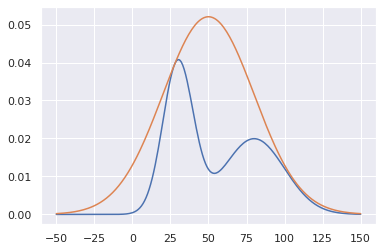

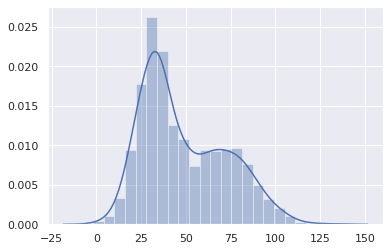

In [33]:
### ACCEPTABLE-REJECTION METHOD (Continuos)###

import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt


sns.set()


def p(x):
    return st.norm.pdf(x, loc=30, scale=10) + st.norm.pdf(x, loc=80, scale=20)

def q(x):
    return st.norm.pdf(x, loc=50, scale=30)

x = np.arange(-50, 151)
k = max(p(x) / q(x))

def rejection_sampling(iter):
    samples = []

    for i in range(iter):
        z = np.random.normal(50, 30)
        u = np.random.uniform(0, 1)
#         print(i)
        if u <= p(z):
            samples.append(z)
    return np.array(samples)


if __name__ == '__main__':
    plt.plot(x, p(x))
    plt.plot(x, k*q(x))
    plt.show()


    s = rejection_sampling(iter=100000)
    sns.distplot(s)

In [28]:
def caracterization(cdf):
    return


In [34]:
# Main function select the method to generate random variates

method = "rejection_sampling"
if method == "inverse":
    inverse()
if method == "composition":
    composition()
if method == "convolution":
    convolution()
if method == "caracterization":
    caracterization()
if method == "accept_reject":
    accept_reject()

# def distribution(argument, u):
#     switcher = {
#         1: inverse,
#         2: composition,
#         3: convolution,
#         4: caracterization,
#         5: accept_reject,
#     }
#     # Get the function from switcher dictionary
#     func = switcher.get(argument, lambda: "Invalid distribution")
#     # Execute the function
#     return func(u)

In [35]:
def translation(cdf):
    return 
# Random Variate X:
X = np.random.exponential(1)
#scale
a = 1
#location
b = 0.1

Y = (a*X) + b
# or
g(x)= (np.power(a,-1))*f((y-b)/a)

Y = pdf(g(x))

SyntaxError: cannot assign to function call (<ipython-input-35-152128fd539e>, line 12)

## Read Trace Files



In [1]:
# Basic example to open trace .pcap
from pcapfile import savefile
# Get a source file
testcap = open('../../repos/ns-3-allinone/ns-3.30/trace1.pcap', 'rb')
# Save data in variable
capfile = savefile.load_savefile(testcap, verbose=True)

# Show data of file
print (capfile)

# Show the packet data
pkt = capfile.packets[0]
pkt.raw()

pkt.timestamp

[+] attempting to load ../../repos/ns-3-allinone/ns-3.30/trace1.pcap
[+] found valid header
[+] loaded 1226 packets
[+] finished loading savefile.
b'little'-endian capture file version 2.4
microsecond time resolution
snapshot length: 262144
linklayer type: LINKTYPE_ETHERNET
number of packets: 1226



1595440758

In [52]:
# Example with various interface type 
from pcapfile.protocols.linklayer import ethernet
from pcapfile.protocols.network import ip
import binascii
eth_frame = ethernet.Ethernet(capfile.packets[0].raw())
print (eth_frame)
ip_packet = ip.IP(binascii.unhexlify(eth_frame.payload))
print (ip_packet)

ethernet from b'64:32:a8:7a:04:86' to b'f8:4f:ad:1c:cc:48' type IPv4
ipv4 packet from b'192.168.1.7' to b'192.168.1.5' carrying 142 bytes


In [122]:
time = []
import pandas as pd

for packet in capfile.packets:
    # print("Packet timestamp ", packet.timestamp)
    # print("Packet ", packet.packet, "\n")

    # show header fields
    
    # print("Magic number", packet.header.contents.magic)             # print("Major version Number", packet.header.contents.major)    # print("Minor version number", packet.header.contents.minor)     # print("Timezone offset", packet.header.contents.tz_off)         # print("Timestamp accuracy", packet.header.contents.ts_acc)      # print("Snapshot lenght", packet.header.contents.snaplen)        # print("Link layer header type",packet.header.contents.ll_type)        
    
    # print("Byte order specifier", packet.header.contents.byteorder)      
    
    # print("Nanosecond resolution",packet.header.contents.ns_resolution)  
    
    # print("\nBytes",packet.packet_len)  
    
    # print("Time",packet.timestamp)  

    from datetime import datetime
    timestamp = datetime.fromtimestamp(packet.timestamp)
    timestamp = timestamp.strftime('%Y-%m-%d %H:%M:%S,%f')
    dt_obj = datetime.strptime(timestamp,
                           '%Y-%m-%d %H:%M:%S,%f')
    millisec = dt_obj.timestamp() * 1000

    
    # show entire packet
    # print("Packet raw", packet.raw(),"\n\n")

ValueError: DataFrame constructor not properly called!

In [94]:
import os


os.system("tshark  -R -e  data.data -e frame.time -e frame.leght -w ../../repos/ns-3-allinone/ns-3.30/trace1.pcap > ../../repos/ns-3-allinone/ns-3.30/tshark_Trace.psml")

256

In [123]:
import pcapy
import dpkt
import time

cap = pcapy.open_live("em2", 65435, True, 100)
(header,packet) = cap.next()
timestamp = header.getts()
print (timestamp)
writer = dpkt.pcap.Writer(open("../../repos/ns-3-allinone/ns-3.30/trace1.pcap", 'wb+'))
while True:
    (header,packet) = cap.next()
    ts = header.getts()
    now = time.time()
    print (ts)
    timestamp = ts[0] + (float(ts[1])/1000000)
    writer.writepkt(packet, timestamp)
    time.sleep(1)
    writer.writepkt(packet, timestamp)
    print('packet printed')

ModuleNotFoundError: No module named 'dpkt'

In [137]:
import numpy as np
df = pd.read_csv('../../repos/ns-3-allinone/ns-3.30/trace.csv',sep = ',', encoding =  'latin1')

np.savetxt(r'../../repos/ns-3-allinone/ns-3.30/scratch/Times.txt', df['Time'], fmt='%f')

np.savetxt(r'../../repos/ns-3-allinone/ns-3.30/scratch/SizePackets.txt', df['Length'], fmt='%f')